In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from connectome_tools import load_flywire

In [2]:
datapath = Path("/Users/chase/Documents/science/drosophila/connectomes/flywire")

In [3]:
neurons, J = load_flywire(datapath, include_spatial=True)
N = len(neurons)

neurons.head()

,root_id,group,nt_type,nt_type_score,da_avg,ser_avg,gaba_avg,glut_avg,ach_avg,oct_avg,...,hemibrain_type,hemilineage,side,nerve,x,y,z,J_idx,J_idx_post,J_idx_pre
0,720575940596125868,LO.LOP,ACH,0.57,0.03,0.00,0.05,0.28,0.57,0.07,...,NaN,NaN,right,NaN,710944.0,262716.0,205680.0,0,0,0
1,720575940597856265,ME,ACH,0.85,0.01,0.00,0.03,0.04,0.85,0.07,...,NaN,NaN,right,NaN,809802.0,350646.0,202660.0,1,1,1
2,720575940597944841,ME.LO,ACH,0.82,0.02,0.00,0.01,0.05,0.82,0.09,...,NaN,NaN,right,NaN,754392.0,331248.0,183360.0,2,2,2
3,720575940598267657,ME,GABA,0.74,0.01,0.01,0.74,0.19,0.03,0.02,...,NaN,NaN,right,NaN,721164.0,298276.0,135720.0,3,3,3
4,720575940599333574,ME,ACH,0.61,0.02,0.00,0.13,0.13,0.61,0.11,...,NaN,NaN,right,NaN,694048.0,316512.0,83840.0,4,4,4


In [4]:
# Create adjacency matrix
Jadj = J.astype(bool)

## Spatial Structure
We calculate below:
- The spatial coordinates of the neuron (a proxy for the soma location),
- The spatial coordinates of the center of mass and average radius of the ingoing (post) and outgoing (pre) synapses of each neuron.

We then plot:
- the histogram for the radii of input and output synapses over neurons
- the histogram of the location of all neurons (soma) and the center of mass of their outgoing synapses. The soma are closer to the exterior of the brain, visible along the x axis (left vs right hemisphere).


In [5]:
# Load synapse coordinates
coordinates = pd.read_csv(datapath / 'coordinates.csv')
syn_coordinates = pd.read_csv(datapath / 'synapse_coordinates.csv')

# Get average coordinates for presynaptic synapses, postsynaptic synapses and 'neuron'
syn_coordinates = syn_coordinates.ffill() # forward fill nan values

presyn_coor = syn_coordinates.groupby('pre_root_id').mean().reset_index().drop(['post_root_id'], axis=1)
presyn_coorVar = syn_coordinates.groupby('pre_root_id').var().reset_index().drop(['post_root_id'], axis=1)
presyn_coor.insert(4, "rho", presyn_coorVar[['x','y','z']].T.sum().pow(0.5))

postsyn_coor = syn_coordinates.groupby('post_root_id').mean().reset_index().drop(['pre_root_id'], axis=1)
postsyn_coorVar = syn_coordinates.groupby('post_root_id').var().reset_index().drop(['pre_root_id'], axis=1)
postsyn_coor.insert(4, "rho", postsyn_coorVar[['x','y','z']].T.sum().pow(0.5))

neur_coor = neurons[["root_id", "x", "y", "z"]].set_index("root_id")

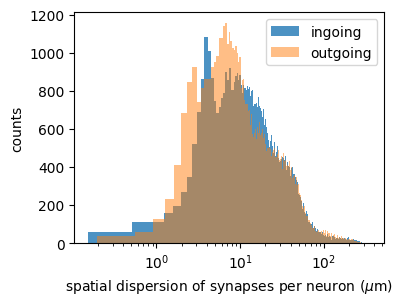

In [6]:
fig  = plt.figure(figsize=[4,3])
ax = fig.add_subplot(111)
postsyn_coor['rho'].mul(1/1000).hist(bins=1000, alpha=0.8, label='ingoing')
presyn_coor['rho'].mul(1/1000).hist(bins=1000, alpha=0.5, label='outgoing')
plt.grid(False)
plt.xlabel(r'spatial dispersion of synapses per neuron ($\mu$m)')
plt.ylabel(r'counts')
plt.legend()
plt.xscale('log')
plt.show()


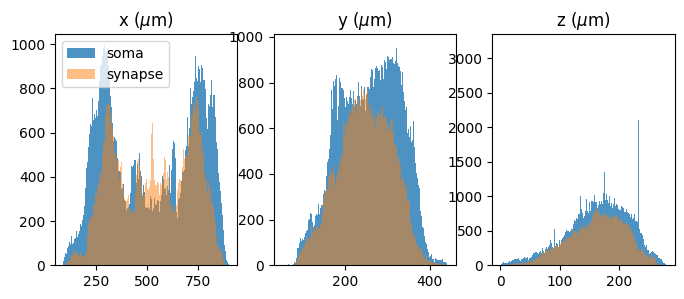

In [7]:
bins = 300
factor = 1./1000. # turn units into um

fig  = plt.figure(figsize=[8,3])
ax = fig.add_subplot(131)
ax.set_title(r'x ($\mu$m)')
neur_coor["x"].mul(factor).hist(bins=bins, label='soma', alpha=0.8)
presyn_coor["x"].mul(factor).hist(bins=bins, alpha=0.5, label='synapse')

plt.legend()
plt.grid(False)
presyn_coor
ax = fig.add_subplot(132)
ax.set_title(r'y ($\mu$m)')
neur_coor["y"].mul(factor).hist(bins=bins, label='soma', alpha=0.8)
presyn_coor["y"].mul(factor).hist(bins=bins, alpha=0.5, label='synapse')
plt.grid(False)
ax = fig.add_subplot(133)
neur_coor["z"].mul(factor).hist(bins=bins, label='soma', alpha=0.8)
presyn_coor["z"].mul(factor).hist(bins=bins, alpha=0.5, label='synapse')
plt.grid(False)
ax.set_title(r'z ($\mu$m)')
plt.show()


## Network properties: in-degree and out-degree
We show below:
- the distribution of indegree and outdegree across neurons. For that, we use the adjacency matrix (no information about the synapse count between to neurons, only whether there is a connection or not). We find that the variability in indegree is slightly larger than in outdegree.
- the correlation between indegree and outdegree per neuron. On average, neurons that project more to other neurons are those that also receive more connections.


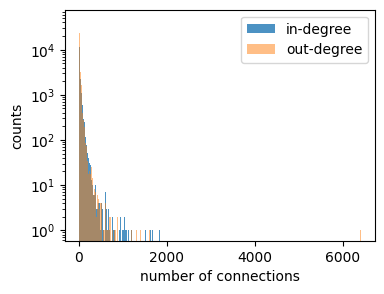

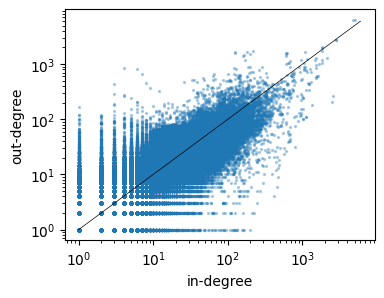

SD of indegree: 49.383734153749344
SD of outdegree: 45.634198672568104


In [8]:
nbins = 1000
plt.figure(figsize=[4,3])
plt.hist(Jadj.sum(1), nbins, alpha=0.8, label='in-degree')
plt.hist(Jadj.T.sum(1), nbins, alpha=0.5, label='out-degree')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('number of connections')
plt.ylabel('counts')
plt.legend()
plt.show()

plt.figure(figsize=[4,3])
plt.scatter(np.array(Jadj.sum(1)), np.array(Jadj.T.sum(1)), s=2, alpha=0.3)#nbins, alpha=0.8, label='in-degree')
#plt.hist(, nbins, alpha=0.5, label='out-degree')
plt.plot([1, 6000], [1,6000], c='k', lw=0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('in-degree')
plt.ylabel('out-degree')
plt.show()
print('SD of indegree: '+str(np.std(Jadj.sum(1))))
print('SD of outdegree: '+str(np.std(Jadj.T.sum(1))))

## Dependence of connectivity with distance
We calculate:
- how the probability of two neurons being connected decays with distance. The probability decays by an order of magnitude within 100 microns.
- how the average synaptic count between connected neurons barely changes as a function of distance.
For both analyses, we subsample the number of pairs of neurons we use.



In [9]:
# Calculate distance between neurons
Nselneur = 10000000#00000000000
rnd_neur1 = np.random.randint(0, N, Nselneur)
rnd_neur2 = np.random.randint(0, N, Nselneur)


p_conns = Jadj[rnd_neur1, rnd_neur2]#Jadj[:,rnd_neur2][rnd_neur1, :]>0.
loc1 = neur_coor.iloc[rnd_neur1].values
loc2 = neur_coor.iloc[rnd_neur2].values
dist_conns = np.sqrt(np.sum((loc1-loc2)**2,1))

In [10]:
# Calculate statistics. 
# We are grouping sampled pairs of neurons into 'Nfold' groups of equal size based on their sorted distance.
# We then take the average within group

ix_ = np.argsort(dist_conns)

Nfold = 20
dist_avg = np.zeros(Nfold)
p_conns_avg = np.zeros(Nfold)

sdist_conns = dist_conns[ix_]
sp_conns = np.array(p_conns)[0][ix_]

Nums = len(ix_)//Nfold
for iN in range(Nfold):
    dist_avg[iN] = np.mean(sdist_conns[iN*Nums:(iN+1)*Nums])
    p_conns_avg[iN] = np.mean(sp_conns[iN*Nums:(iN+1)*Nums])

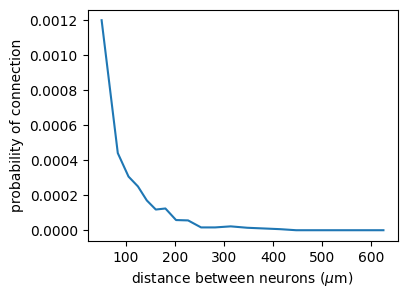

In [11]:
plt.figure(figsize=[4,3])
plt.plot(dist_avg/1000, p_conns_avg)
plt.xlabel(r'distance between neurons ($\mu$m)')
plt.ylabel(r'probability of connection')
plt.show()

In [12]:
conns = pd.read_csv(datapath / 'connections.csv')
conns.head()

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA


In [13]:
neur_coor

,x,y,z
root_id,,,
720575940596125868,710944.0,262716.0,205680.0
720575940597856265,809802.0,350646.0,202660.0
720575940597944841,754392.0,331248.0,183360.0
720575940598267657,721164.0,298276.0,135720.0
720575940599333574,694048.0,316512.0,83840.0
...,...,...,...
720575940661335681,479150.0,351822.0,175460.0
720575940661336193,264160.0,156468.0,192540.0
720575940661337217,407744.0,106944.0,190120.0


In [14]:
# Calculate distance between pairs of connected neurons
Nsyns = 10000
rnd_syns = np.random.choice(len(conns), Nsyns, replace=False)
dists = np.zeros(Nsyns)
counts = np.zeros(Nsyns)
for isyn, syn in enumerate(rnd_syns):
    preI = conns.pre_root_id.iloc[syn]
    postI = conns.post_root_id.iloc[syn]
    loc_pre = neur_coor.loc[preI].values
    loc_post = neur_coor.loc[postI].values
    
    counts[isyn] = conns.syn_count[syn]
    dists[isyn] = np.sqrt(np.sum((loc_pre-loc_post)**2))

In [15]:
# same averaging procedure as for the plot above
ix_ = np.argsort(dists)
Nfold = 20
dist_avg = np.zeros(Nfold)
dist_std = np.zeros(Nfold)

syncount_avg = np.zeros(Nfold)
syncount_std = np.zeros(Nfold)


sdist = dists[ix_]
s_syncount = counts[ix_]

Nums = len(ix_)//Nfold
for iN in range(Nfold):
    dist_avg[iN] = np.mean(sdist[iN*Nums:(iN+1)*Nums])
    dist_std[iN] = np.std(sdist[iN*Nums:(iN+1)*Nums])/np.sqrt(Nums)
    
    syncount_avg[iN] = np.mean(s_syncount[iN*Nums:(iN+1)*Nums])
    syncount_std[iN] = np.std(s_syncount[iN*Nums:(iN+1)*Nums])/np.sqrt(Nums)

Text(0, 0.5, 'synaptic count')

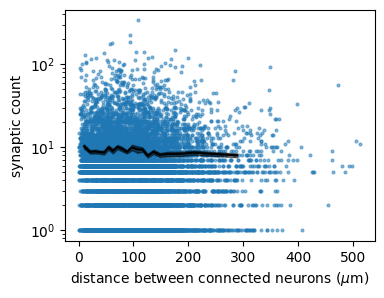

In [16]:
plt.figure(figsize=[4,3])
plt.scatter(dists/1000., counts, s=4, alpha=0.5)
plt.plot(dist_avg/1000., syncount_avg, c='k')
plt.fill_between(dist_avg/1000., syncount_avg-syncount_std, syncount_avg+syncount_std, color='k', alpha=0.5)
#plt.fill_betweenx(syncount_avg, dist_avg/1000.-dist_std/1000., dist_avg/1000.+dist_std/1000., color='k', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'distance between connected neurons ($\mu$m)')
plt.ylabel(r'synaptic count')


## Ideas to explore
- Could we build connectomes that have the same spatial structure using a directed configuration model?
- How different are the statistics of such a generated connectome? For instance, compare the statistics of bidirectional connections between the FlyWire data and the generated connectome
- What if we don't take the spatial structure into account?

To generate directed graphs, take a look at the package `networkx`, in particular the class `directed_configuration_model`

 